In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import shap

Read data in and clean

In [2]:
# Import csv file prices_prod
source_df = pd.read_csv('./Resources/prices_prod.csv', parse_dates=['date'], index_col= 'date' )
source_df.reset_index(inplace=True)
source_df.sort_index(inplace=True)
source_df.head()
source_df.dropna()

,date,year_month,geography,type,avg_price,prices_total_volume,units_4046,units_4225,units_4770,total_bags,s_bags,l_bags,xl_bags,status,prod_total_volume,california,chile,mexico,peru,colombia
0,2018-01-07,1/1/2018,Albany,conventional,1.13,98540.22,2940.63,76192.61,42.63,19364.35,8633.09,10707.93,23.33,actual,45670156,899349,519433,44251374,0,0
1,2018-01-07,1/1/2018,Albany,organic,1.54,4816.90,43.51,412.17,0.00,4361.22,4357.89,3.33,0.00,actual,45670156,899349,519433,44251374,0,0
2,2018-01-07,1/1/2018,Atlanta,conventional,0.98,713915.80,364463.12,47869.41,1459.65,300123.62,217644.43,78287.66,4191.53,actual,45670156,899349,519433,44251374,0,0
3,2018-01-07,1/1/2018,Atlanta,organic,1.53,15714.11,405.37,4195.19,0.00,11113.55,7883.61,3229.94,0.00,actual,45670156,899349,519433,44251374,0,0
4,2018-01-07,1/1/2018,Baltimore/Washington,conventional,1.50,771313.78,89883.07,466602.79,4167.07,210660.85,189304.53,21356.32,0.00,actual,45670156,899349,519433,44251374,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14467,2020-09-06,9/1/2020,TotalUS,organic,1.62,1754057.30,105106.37,144137.69,4186.01,1500627.23,848427.68,652190.75,8.80,actual,52693480,8453470,0,39925907,4314102,0
14468,2020-09-06,9/1/2020,West,conventional,0.95,9026449.59,1975837.16,1152252.54,33199.60,5864954.14,2726358.78,3060566.48,78028.88,actual,52693480,8453470,0,39925907,4314102,0
14469,2020-09-06,9/1/2020,West,organic,1.58,315771.42,31032.50,28880.42,1192.43,254666.07,100807.93,153849.34,8.80,actual,52693480,8453470,0,39925907,4314102,0
14470,2020-09-06,9/1/2020,WestTex/NewMexico,conventional,0.75,1212992.28,397029.46,76486.29,39407.07,700069.46,482659.19,215394.65,2015.62,actual,52693480,8453470,0,39925907,4314102,0


In [3]:
# Drop the non-beneficial columns, 'status' and 'prod'.
source_df.drop(['year_month', 'status', 'prices_total_volume', 'total_bags', 'prod_total_volume'],axis=1, inplace=True)
source_df

,date,geography,type,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,california,chile,mexico,peru,colombia
0,2018-01-07,Albany,conventional,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33,899349,519433,44251374,0,0
1,2018-01-07,Albany,organic,1.54,43.51,412.17,0.00,4357.89,3.33,0.00,899349,519433,44251374,0,0
2,2018-01-07,Atlanta,conventional,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53,899349,519433,44251374,0,0
3,2018-01-07,Atlanta,organic,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.00,899349,519433,44251374,0,0
4,2018-01-07,Baltimore/Washington,conventional,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00,899349,519433,44251374,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14467,2020-09-06,TotalUS,organic,1.62,105106.37,144137.69,4186.01,848427.68,652190.75,8.80,8453470,0,39925907,4314102,0
14468,2020-09-06,West,conventional,0.95,1975837.16,1152252.54,33199.60,2726358.78,3060566.48,78028.88,8453470,0,39925907,4314102,0
14469,2020-09-06,West,organic,1.58,31032.50,28880.42,1192.43,100807.93,153849.34,8.80,8453470,0,39925907,4314102,0
14470,2020-09-06,WestTex/NewMexico,conventional,0.75,397029.46,76486.29,39407.07,482659.19,215394.65,2015.62,8453470,0,39925907,4314102,0


In [4]:
# Drop rows that are totals for included sub areas and thus duplicates
source_df = source_df.drop(source_df[(source_df.geography == 'California') |  (source_df.geography == 'Southeast') |
                                   (source_df.geography == 'TotalUS') |
                                   (source_df.geography == 'Midsouth') |
                                   (source_df.geography == 'Northeast') |
                                   (source_df.geography == 'Southeast') |
                                   (source_df.geography == 'West') ].index)
source_df

,date,geography,type,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,california,chile,mexico,peru,colombia
0,2018-01-07,Albany,conventional,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33,899349,519433,44251374,0,0
1,2018-01-07,Albany,organic,1.54,43.51,412.17,0.00,4357.89,3.33,0.00,899349,519433,44251374,0,0
2,2018-01-07,Atlanta,conventional,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53,899349,519433,44251374,0,0
3,2018-01-07,Atlanta,organic,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.00,899349,519433,44251374,0,0
4,2018-01-07,Baltimore/Washington,conventional,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00,899349,519433,44251374,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14463,2020-09-06,Syracuse,organic,1.47,263.28,151.82,0.00,3676.17,508.41,0.00,8453470,0,39925907,4314102,0
14464,2020-09-06,Tampa,conventional,0.83,295153.76,19274.90,150.36,340468.87,28822.22,13057.78,8453470,0,39925907,4314102,0
14465,2020-09-06,Tampa,organic,1.63,115.22,0.00,0.00,3427.70,1438.89,0.00,8453470,0,39925907,4314102,0
14470,2020-09-06,WestTex/NewMexico,conventional,0.75,397029.46,76486.29,39407.07,482659.19,215394.65,2015.62,8453470,0,39925907,4314102,0


In [5]:
# Correct the type catagory
source_df.loc[source_df['type'] == 'conventional ', 'type'] = 'conventional'
source_df.groupby('type').size()

type
conventional    6432
organic         6432
dtype: int64

In [6]:
source_df

,date,geography,type,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,california,chile,mexico,peru,colombia
0,2018-01-07,Albany,conventional,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33,899349,519433,44251374,0,0
1,2018-01-07,Albany,organic,1.54,43.51,412.17,0.00,4357.89,3.33,0.00,899349,519433,44251374,0,0
2,2018-01-07,Atlanta,conventional,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53,899349,519433,44251374,0,0
3,2018-01-07,Atlanta,organic,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.00,899349,519433,44251374,0,0
4,2018-01-07,Baltimore/Washington,conventional,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00,899349,519433,44251374,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14463,2020-09-06,Syracuse,organic,1.47,263.28,151.82,0.00,3676.17,508.41,0.00,8453470,0,39925907,4314102,0
14464,2020-09-06,Tampa,conventional,0.83,295153.76,19274.90,150.36,340468.87,28822.22,13057.78,8453470,0,39925907,4314102,0
14465,2020-09-06,Tampa,organic,1.63,115.22,0.00,0.00,3427.70,1438.89,0.00,8453470,0,39925907,4314102,0
14470,2020-09-06,WestTex/NewMexico,conventional,0.75,397029.46,76486.29,39407.07,482659.19,215394.65,2015.62,8453470,0,39925907,4314102,0


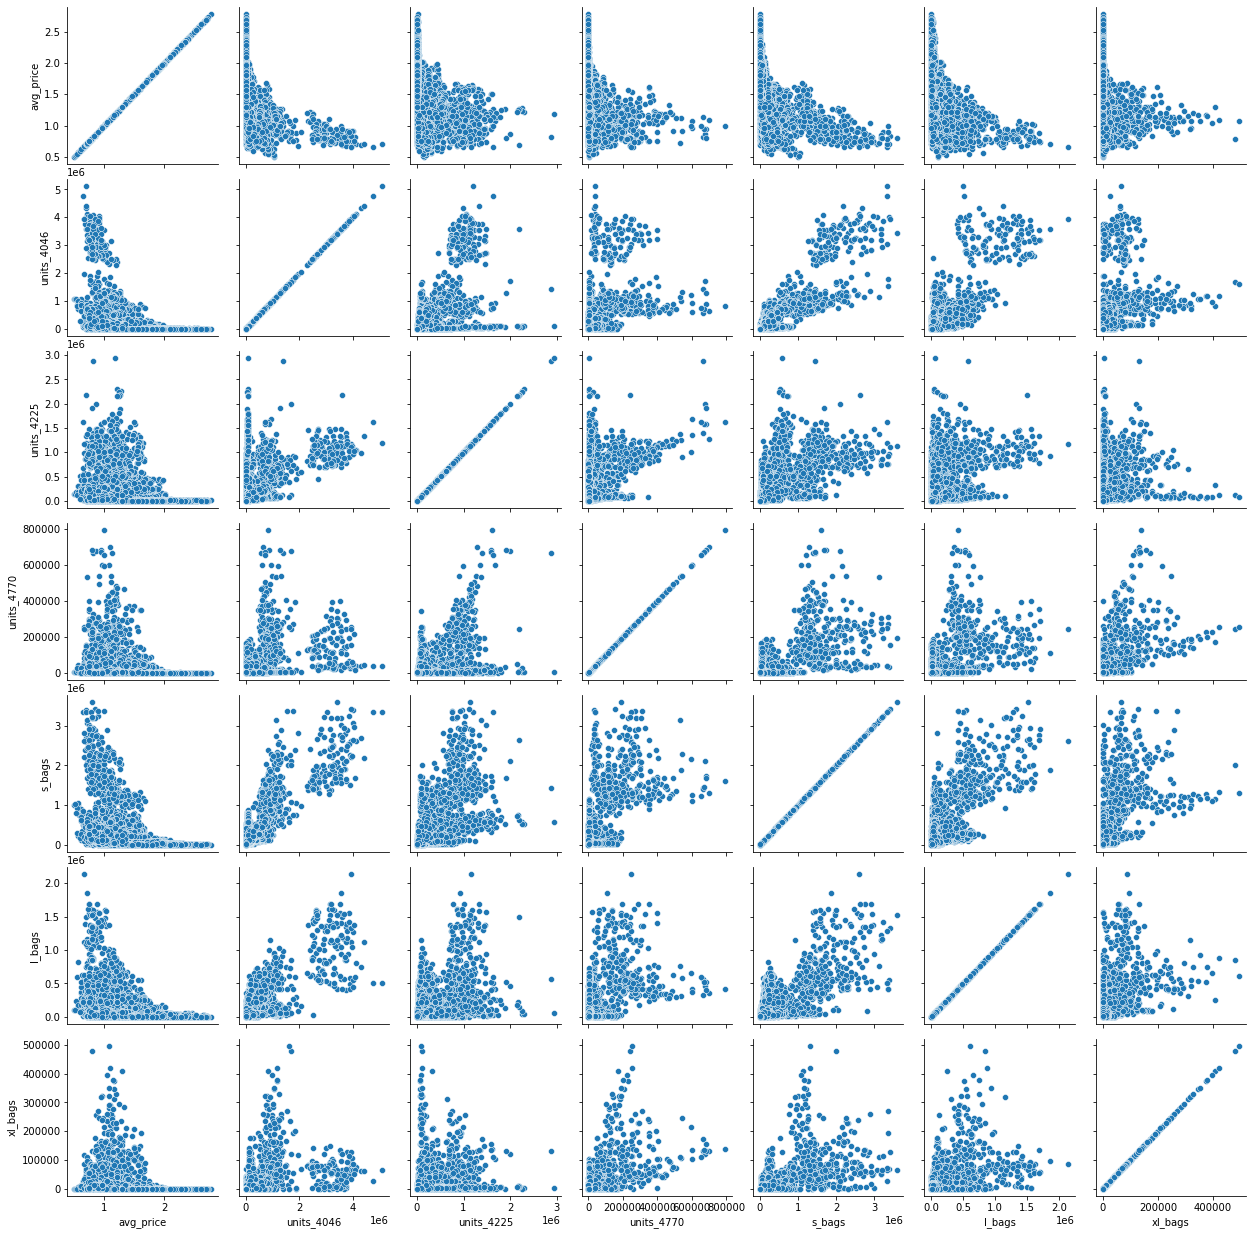

In [7]:
# Compare prices to volumes
g = sns.PairGrid(source_df[['avg_price', 'units_4046', 'units_4225',
                           'units_4770', 's_bags', 'l_bags', 'xl_bags']])
g.map(sns.scatterplot)

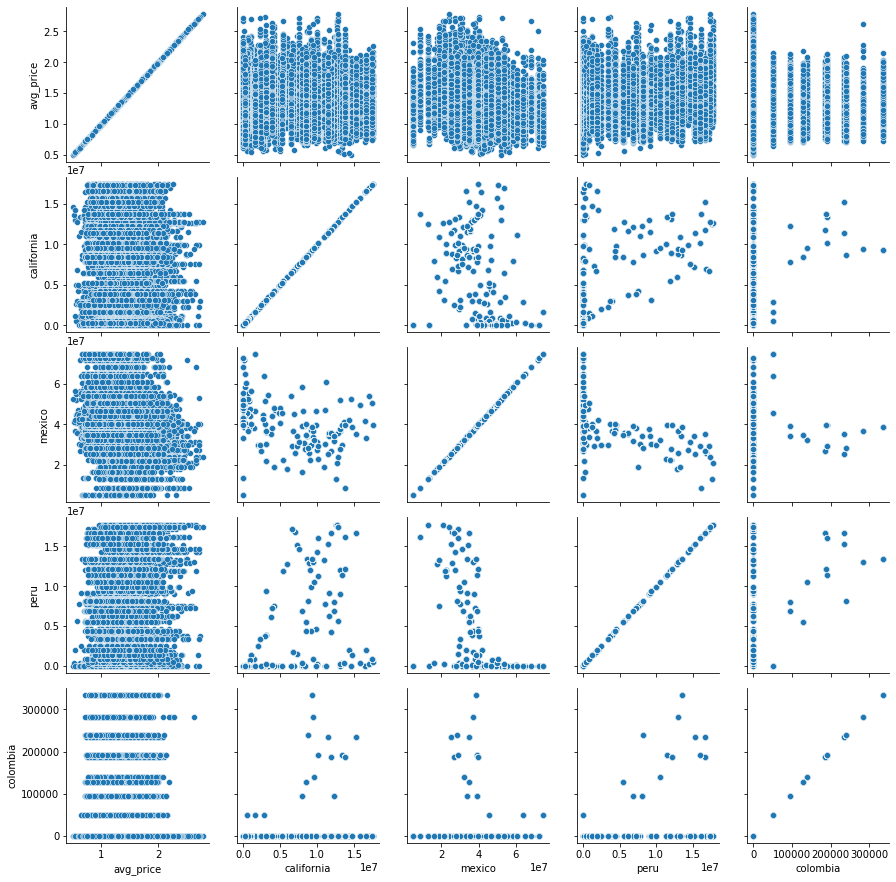

In [8]:
# Compare avg price to production
g = sns.PairGrid(source_df[['avg_price', 'california', 'mexico',
                           'peru', 'colombia']])
g.map(sns.scatterplot)

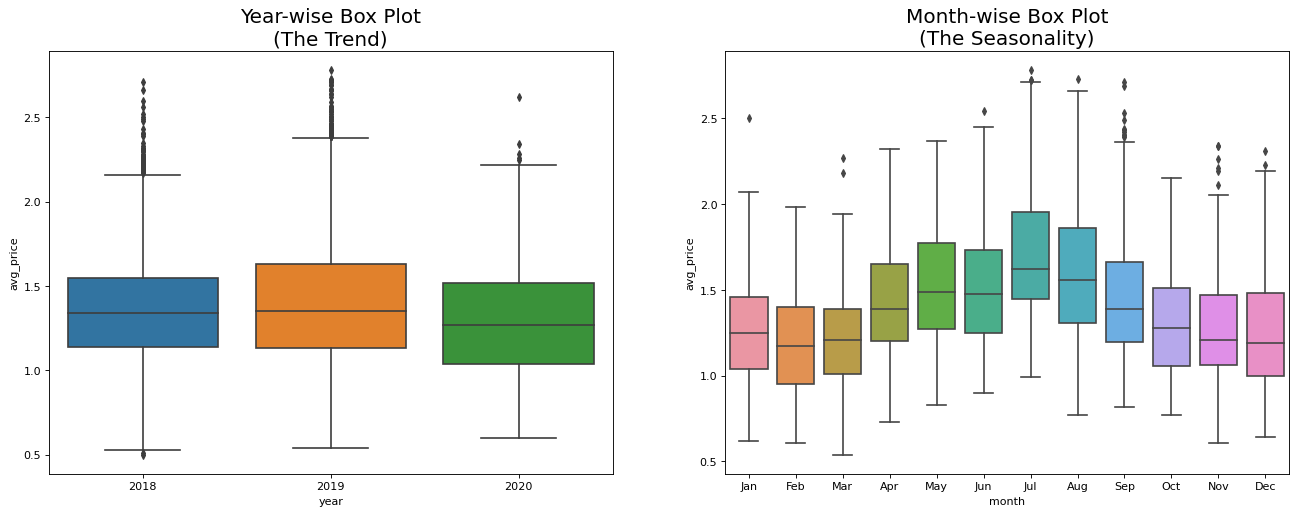

In [9]:
# Prepare data
source_df['year'] = [d.year for d in source_df.date]
source_df['month'] = [d.strftime('%b') for d in source_df.date]
years = source_df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='avg_price', data=source_df, ax=axes[0])
sns.boxplot(x='month', y='avg_price', data=source_df.loc[~source_df.year.isin([2018, 2020]), :])            
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

LSTM Data Preparation

In [10]:
# Drop the all date to fit LSTM model.
source_df.drop(['year', 'month'],axis=1, inplace=True)

# Re-order column names
source_df = source_df[['date', 'avg_price', 'units_4046', 'units_4225',
                       'units_4770', 's_bags', 'l_bags', 'xl_bags',
                      'california', 'chile', 'mexico', 'peru', 'colombia',
                      'geography', 'type']]
source_df

,date,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,california,chile,mexico,peru,colombia,geography,type
0,2018-01-07,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33,899349,519433,44251374,0,0,Albany,conventional
1,2018-01-07,1.54,43.51,412.17,0.00,4357.89,3.33,0.00,899349,519433,44251374,0,0,Albany,organic
2,2018-01-07,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53,899349,519433,44251374,0,0,Atlanta,conventional
3,2018-01-07,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.00,899349,519433,44251374,0,0,Atlanta,organic
4,2018-01-07,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00,899349,519433,44251374,0,0,Baltimore/Washington,conventional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14463,2020-09-06,1.47,263.28,151.82,0.00,3676.17,508.41,0.00,8453470,0,39925907,4314102,0,Syracuse,organic
14464,2020-09-06,0.83,295153.76,19274.90,150.36,340468.87,28822.22,13057.78,8453470,0,39925907,4314102,0,Tampa,conventional
14465,2020-09-06,1.63,115.22,0.00,0.00,3427.70,1438.89,0.00,8453470,0,39925907,4314102,0,Tampa,organic
14470,2020-09-06,0.75,397029.46,76486.29,39407.07,482659.19,215394.65,2015.62,8453470,0,39925907,4314102,0,WestTex/NewMexico,conventional


In [11]:
source_df.to_csv('lstm_cleaned.csv')

Data pipeline including lags

In [12]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# read in data
dataset = pd.read_csv('lstm_cleaned.csv', header=0, index_col=0)

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# Reframe as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, 197:,], axis=1, inplace=True)
reframed.drop(reframed.index[0], inplace=True)
print(reframed)

       var1(t-1)     var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.276316  5.749934e-04   0.025932   0.000054   0.002517   0.005010   
2       0.456140  8.507687e-06   0.000140   0.000000   0.001269   0.000002   
3       0.210526  7.126496e-02   0.016292   0.001837   0.063513   0.036630   
4       0.451754  7.926365e-05   0.001428   0.000000   0.002298   0.001511   
5       0.438596  1.757520e-02   0.158805   0.005243   0.055242   0.009992   
...          ...           ...        ...        ...        ...        ...   
11431   0.333333  7.076965e-03   0.003029   0.002047   0.011639   0.021785   
11432   0.552632  5.866022e-07   0.000214   0.000000   0.000739   0.001800   
11433   0.434211  4.854915e-03   0.203617   0.000737   0.071659   0.054811   
11434   0.666667  3.324079e-05   0.000986   0.000000   0.010978   0.001009   
11435   0.285088  6.083456e-03   0.020234   0.004053   0.042344   0.011580   

       var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var188

In [14]:
# split into train and test sets
values = reframed
n_train = 9505 # 2018 through 2019
n_features = 197
train = values[:n_train]
test = values[n_train:]
train_y = train['var1(t)']
train_X = train.drop(['var1(t)'], axis=1)
test_y = test['var1(t)'].values
test_X = test.drop(['var1(t)'], axis=1)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(9505, 1, 196) (9505,) (1930, 1, 196) (1930,)


Instanciate and fit LSTM model with lags

Epoch 1/100
133/133 - 1s - loss: 0.1185 - val_loss: 0.1088
Epoch 2/100
133/133 - 0s - loss: 0.0947 - val_loss: 0.1577
Epoch 3/100
133/133 - 0s - loss: 0.0916 - val_loss: 0.1176
Epoch 4/100
133/133 - 0s - loss: 0.0989 - val_loss: 0.1182
Epoch 5/100
133/133 - 0s - loss: 0.1036 - val_loss: 0.0892
Epoch 6/100
133/133 - 0s - loss: 0.0857 - val_loss: 0.0999
Epoch 7/100
133/133 - 0s - loss: 0.0829 - val_loss: 0.1053
Epoch 8/100
133/133 - 0s - loss: 0.0797 - val_loss: 0.0889
Epoch 9/100
133/133 - 0s - loss: 0.0800 - val_loss: 0.0860
Epoch 10/100
133/133 - 0s - loss: 0.0794 - val_loss: 0.0975
Epoch 11/100
133/133 - 0s - loss: 0.0783 - val_loss: 0.1106
Epoch 12/100
133/133 - 0s - loss: 0.0786 - val_loss: 0.1005
Epoch 13/100
133/133 - 0s - loss: 0.0781 - val_loss: 0.0865
Epoch 14/100
133/133 - 0s - loss: 0.0790 - val_loss: 0.0814
Epoch 15/100
133/133 - 0s - loss: 0.0810 - val_loss: 0.0815
Epoch 16/100
133/133 - 0s - loss: 0.0820 - val_loss: 0.0799
Epoch 17/100
133/133 - 0s - loss: 0.0809 - val_lo

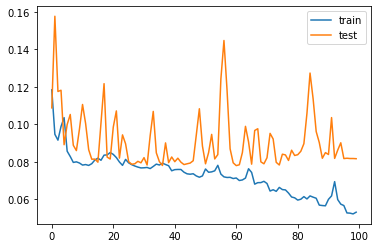

Test RMSE: 0.234


In [15]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Multiple Lags Model

(12, 14, 14) (12,) (11410, 14, 14) (11410,)
Epoch 1/50
1/1 - 1s - loss: 0.0256 - val_loss: 0.0448
Epoch 2/50
1/1 - 0s - loss: 0.0218 - val_loss: 0.0425
Epoch 3/50
1/1 - 0s - loss: 0.0180 - val_loss: 0.0407
Epoch 4/50
1/1 - 0s - loss: 0.0143 - val_loss: 0.0388
Epoch 5/50
1/1 - 0s - loss: 0.0128 - val_loss: 0.0375
Epoch 6/50
1/1 - 0s - loss: 0.0087 - val_loss: 0.0376
Epoch 7/50
1/1 - 0s - loss: 0.0076 - val_loss: 0.0369
Epoch 8/50
1/1 - 0s - loss: 0.0053 - val_loss: 0.0368
Epoch 9/50
1/1 - 0s - loss: 0.0058 - val_loss: 0.0369
Epoch 10/50
1/1 - 0s - loss: 0.0052 - val_loss: 0.0370
Epoch 11/50
1/1 - 0s - loss: 0.0056 - val_loss: 0.0373
Epoch 12/50
1/1 - 0s - loss: 0.0068 - val_loss: 0.0373
Epoch 13/50
1/1 - 0s - loss: 0.0070 - val_loss: 0.0370
Epoch 14/50
1/1 - 0s - loss: 0.0067 - val_loss: 0.0367
Epoch 15/50
1/1 - 0s - loss: 0.0059 - val_loss: 0.0365
Epoch 16/50
1/1 - 0s - loss: 0.0057 - val_loss: 0.0361
Epoch 17/50
1/1 - 0s - loss: 0.0051 - val_loss: 0.0356
Epoch 18/50
1/1 - 0s - loss: 0

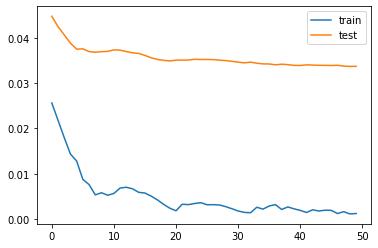

Test RMSE: 0.331


In [16]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('lstm_cleaned.csv', header=0, index_col=0)
values = dataset.values

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# specify the number of lag times
n_times = 14
n_features = 14

# frame as supervised learning
reframed = series_to_supervised(scaled, n_times, 1)
#print(reframed.shape)
 
# drop columns we don't want to predict
#reframed.drop(reframed.iloc[:, 168:,], axis=1, inplace=True)
#reframed.drop(reframed.index[0], inplace=True)
    
# split into train and test sets
values = reframed.values
n_train = 12 # 2018 through 2019
train = values[:n_train, :]
test = values[n_train:, :]

#split into input and outputs
n_obs = n_times * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(test_X.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_times, n_features))
test_X = test_X.reshape((test_X.shape[0], n_times, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_times*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [18]:
print(inv_yhat.shape)

(11410,)
